<a href="https://colab.research.google.com/github/SBShimm/Aiffel/blob/master/exploration/Exploration7_SB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 고양이 수염 붙이기!

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import dlib

print(cv2.__version__)
print(dlib.__version__)

4.6.0
19.24.0


## 1. 이미지 불러오기  
opencv에서는 BGR을 쓰기에 RGB로 변환해야함

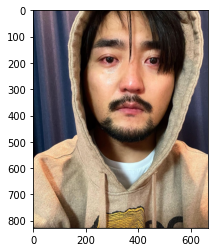

In [2]:
img_path = '/content/drive/MyDrive/Colab/Datasets/cat-face/'
img_bgr = cv2.imread(img_path + 'face/1.png')
img_show = img_bgr.copy()
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

## 2. 얼굴 위치 찾기  
다음은 Object detection 기술을 이용해 얼굴을 찾아봅니다.  
dlib의 face detector는 HOG와 SVM을 사용해 얼굴을 찾습니다.

In [3]:
detector_hog = dlib.get_frontal_face_detector()

In [4]:
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)

rectangles[[(142, 40) (605, 502)]]


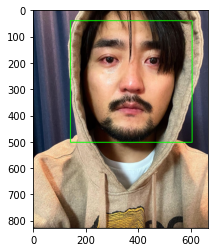

In [5]:
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [6]:
print(l, t, r, b)
print(dlib_rects[0].height(), dlib_rects[0].width())

142 40 605 502
463 464


## 3. 얼굴 랜드마크 face landmark  
이제 고양이 코를 붙이기 위해 detection을 통해 찾아낸 얼굴에 이목구비를 landmark 해줍니다. 객체 내부에 점을 찾는 기술을 object keypoing estimation이라고 합니다.  
Dilb의 face landmark는 ibug 300-W 데이터셋으로 학습한 68개의 점을 이용한 랜드마크를 시행합니다.

In [7]:
landmark_predictor = dlib.shape_predictor('/content/drive/MyDrive/Colab/Datasets/cat-face/model/shape_predictor_68_face_landmarks.dat')


In [8]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


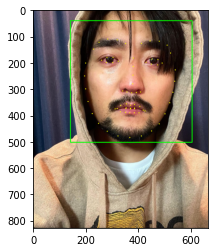

In [9]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [10]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    w = dlib_rect.width()
    h = dlib_rect.height()
    x = landmark[33][0]
    y = landmark[33][1] + (h // 2)
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(x,y) : (375,545)
(w,h) : (464,463)


## 4. 스티커 붙이기

(463, 464, 3)


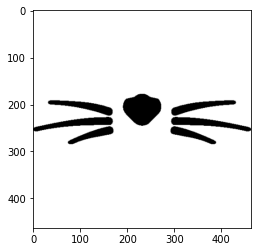

In [11]:
sticker_path = '/content/drive/MyDrive/Colab/Datasets/cat-face/whiskers/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w, h))
print (img_sticker.shape)
plt.imshow(img_sticker)
plt.show()

In [12]:
refined_x = x - w // 2
refined_y = y - h
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (143,82)


In [13]:
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (143,82)


In [14]:
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

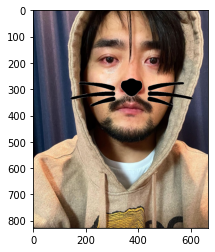

In [15]:
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

잘 붙었다.  

## 6. 다양하게 적용해보기
다양한 다른 사진에도 적용하기 위해 class를 만들어서 쉽게 수염을 붙여보자.

In [16]:
class StickerAttacher:
  rotate_ptn = [cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_180, cv2.ROTATE_90_COUNTERCLOCKWISE]
  detector = dlib.get_frontal_face_detector()
  predictor = dlib.shape_predictor('/content/drive/MyDrive/Colab/Datasets/cat-face/model/shape_predictor_68_face_landmarks.dat')

  def __init__(self, image_path):
    self.img_bgr = cv2.imread(image_path)
    self.img_rgb = cv2.cvtColor(self.img_bgr, cv2.COLOR_BGR2RGB)
    self.dlib_rects = None
    self.list_landmarks = None
    self.sticker = None
    self.is_rotate_detect = False
    self.rotate_degree = 0

  def face_detect(self, show_image=False, rotate_detect=False):
    self.dlib_rects = StickerAttacher.detector(self.img_rgb, 1)
    
    # 회전 탐색을 위해 추가
    if rotate_detect == True:
      if len(self.dlib_rects) == 0:
        for rotate in range(0, 3):
          detect_img = cv2.rotate(self.img_rgb, StickerAttacher.rotate_ptn[rotate])
          dlib_rect = StickerAttacher.detector(detect_img, 1)
          if len(dlib_rect) != 0:
            self.is_rotate_detect = True
            self.dlib_rects = dlib_rect
            self.rotate = rotate
            self.img_rgb = detect_img
            self.img_bgr = cv2.cvtColor(self.img_rgb, cv2.COLOR_RGB2BGR)
            break
        
    img = self.img_bgr.copy()

    for dlib_rect in self.dlib_rects:
      l = dlib_rect.left()
      t = dlib_rect.top()
      r = dlib_rect.right()
      b = dlib_rect.bottom()

      cv2.rectangle(img, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
    if show_image:
      plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
      plt.show()

  def landmark(self, show_image=False):
    self.list_landmarks = []
    img = self.img_bgr.copy()

    for dlib_rect in self.dlib_rects:
      points = StickerAttacher.predictor(self.img_rgb, dlib_rect)
      list_points = list(map(lambda p: (p.x, p.y), points.parts()))
      self.list_landmarks.append(list_points)

    for landmark in self.list_landmarks:
      for point in landmark:
        cv2.circle(img, point, 2, (0, 255, 255), -1)

    if show_image:
      plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
      plt.show()

  def add_sticker(self, sticker_path, show_image=True, rotate_sticker=False):
    img = self.img_bgr.copy()
    for dlib_rect, landmark in zip(self.dlib_rects, self.list_landmarks):
      w = dlib_rect.width()
      h = dlib_rect.height()
      x = landmark[33][0]
      y = landmark[33][1] + (h // 2)

      center = x1, y1 = w // 2, h // 2
      self.sticker = cv2.resize(cv2.imread(sticker_path), (w, h))

      # 수염 회전을 위해 추가함
      if rotate_sticker == True:
        radian = np.arctan2(landmark[35][1] - landmark[31][1], landmark[35][0] - landmark[31][0])
        degree = radian * 180 / np.pi
        h1, w1 = self.sticker.shape[:2]
        x1, y1 = w1 // 2, h1 // 2
        rotation = cv2.getRotationMatrix2D((x1, y1), degree * -1, 1)
        self.sticker = cv2.warpAffine(self.sticker, rotation, (w, h), borderValue=[255, 255, 255])
      
      refined_x = x - w // 2
      refined_y = y - h

      if refined_x < 0: 
        self.sticker = self.sticker[:, -refined_x:]
        refined_x = 0
      if refined_y < 0:
        self.sticker = self.sticker[-refined_y:, :]
        refined_y = 0

      sticker_area = img[refined_y:refined_y+self.sticker.shape[0], refined_x:refined_x+self.sticker.shape[1]]
      img[refined_y:refined_y+self.sticker.shape[0], refined_x:refined_x+self.sticker.shape[1]] = \
          np.where(self.sticker!=0,sticker_area,self.sticker).astype(np.uint8)
    
    # 회전탐색인 경우 원래대로 다시 회전
    if self.is_rotate_detect == True:
      img = cv2.rotate(img, StickerAttacher.rotate_ptn[2-self.rotate])

    if show_image:
      plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
      plt.show()

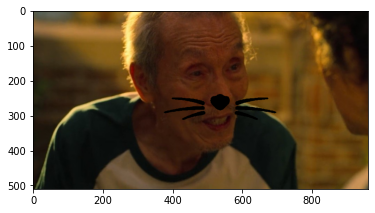

In [17]:
stickerAttacher = StickerAttacher(img_path + 'face/6.png')
stickerAttacher.face_detect()
stickerAttacher.landmark()
stickerAttacher.add_sticker(sticker_path)

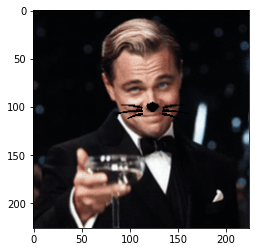

In [18]:
stickerAttacher = StickerAttacher(img_path + 'face/2.png')
stickerAttacher.face_detect()
stickerAttacher.landmark()
stickerAttacher.add_sticker(sticker_path)

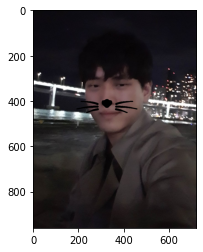

In [19]:
stickerAttacher = StickerAttacher(img_path + 'face/3.png')
stickerAttacher.face_detect()
stickerAttacher.landmark()
stickerAttacher.add_sticker(sticker_path)

여기까지는 고양이 수염이 제대로 잘 붙었다.

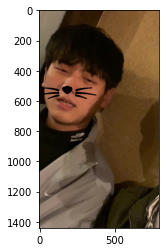

In [20]:
stickerAttacher = StickerAttacher(img_path + 'face/4.png')
stickerAttacher.face_detect()
stickerAttacher.landmark()
stickerAttacher.add_sticker(sticker_path)

이 사진은 얼굴이 조금 틀어져있어서 그런지 고양이 수염이 조금 어색하다.

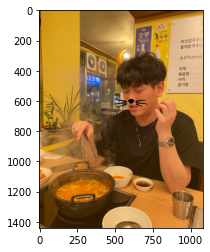

In [21]:
stickerAttacher = StickerAttacher(img_path + 'face/5.png')
stickerAttacher.face_detect()
stickerAttacher.landmark()
stickerAttacher.add_sticker(sticker_path)

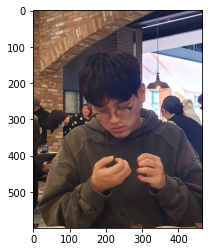

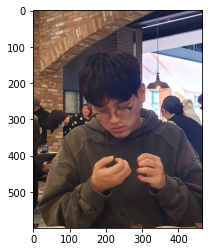

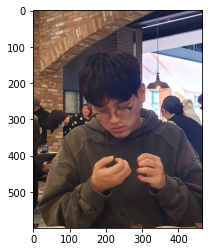

In [22]:
stickerAttacher = StickerAttacher(img_path + 'face/7.png')
stickerAttacher.face_detect(True)
stickerAttacher.landmark(True)
stickerAttacher.add_sticker(sticker_path)

이 사진은 안경을 써서인지 고개를 숙이고 있어서인지 얼굴자체를 인식하지 못했다.

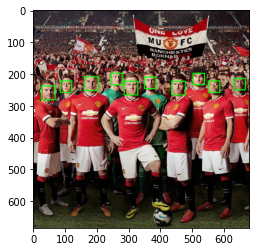

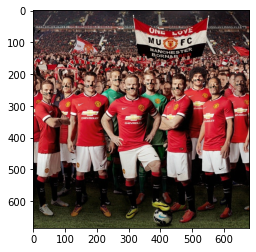

In [23]:
stickerAttacher = StickerAttacher(img_path + 'face/8.png')
stickerAttacher.face_detect(True)
stickerAttacher.landmark()
stickerAttacher.add_sticker(sticker_path)

단체사진의 경우에는 가까이에서 얼굴을 인식한 부분에는 모두 스티커가 들어갔지만 멀리 있는 사람들은 얼굴을 인식할 수가 없었다. 

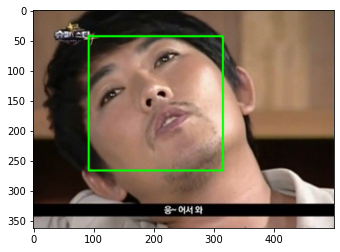

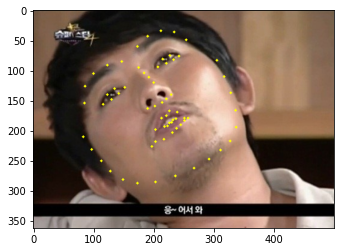

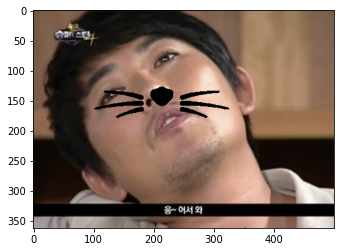

In [24]:
stickerAttacher = StickerAttacher(img_path + 'face/9.png')
stickerAttacher.face_detect(True)
stickerAttacher.landmark(True)
stickerAttacher.add_sticker(sticker_path)

이 사진도 고개를 돌리고 있어서 스티커가 매우 어색하게 붙었다.  
여기서 스티커를 똑바로 붙이기 위해 코가 기울어진 각도(랜드마크의 31번 점과 35번 점의 기울기를 활용)를 tan의 역함수인 arctan를 이용하여 구한 후 수염을 회전시키도록 해보았다.  
add_sticker 함수에 rotate_sticker 파라미터로 옵션을 설정할 수 있도록 추가하였다.

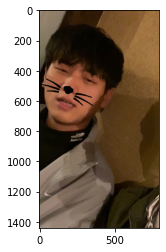

In [25]:
stickerAttacher = StickerAttacher(img_path + 'face/4.png')
stickerAttacher.face_detect()
stickerAttacher.landmark()
stickerAttacher.add_sticker(sticker_path, rotate_sticker=True)

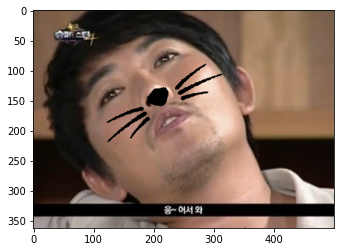

In [26]:
stickerAttacher = StickerAttacher(img_path + 'face/9.png')
stickerAttacher.face_detect()
stickerAttacher.landmark()
stickerAttacher.add_sticker(sticker_path, rotate_sticker=True)

적용해주니 코가 잘 붙었다.

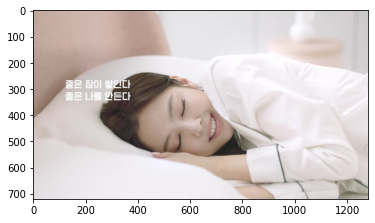

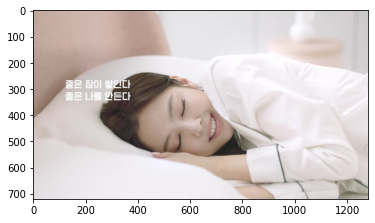

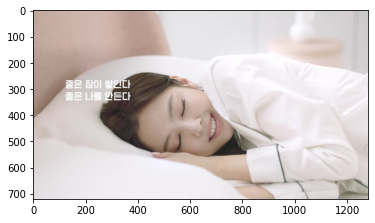

In [27]:
stickerAttacher = StickerAttacher(img_path + 'face/10.png')
stickerAttacher.face_detect(True)
stickerAttacher.landmark(True)
stickerAttacher.add_sticker(sticker_path, rotate_sticker=True)

다음은 누워있는 사진을 사용해 보았는데 누워있는 사진 또한 얼굴이 인식이 되지 않았다.

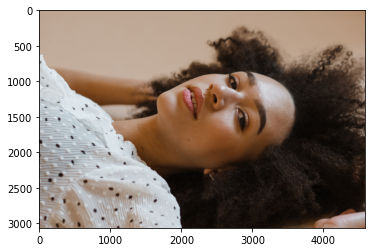

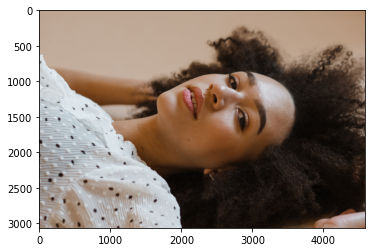

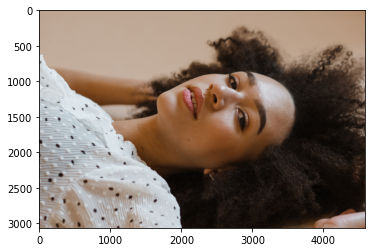

In [28]:
stickerAttacher = StickerAttacher(img_path + 'face/11.png')
stickerAttacher.face_detect(True)
stickerAttacher.landmark(True)
stickerAttacher.add_sticker(sticker_path, rotate_sticker=True)

이 사진도 마찬가지다.

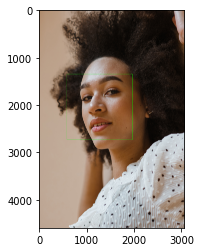

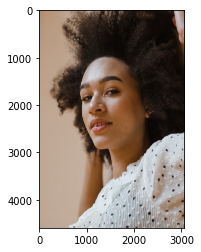

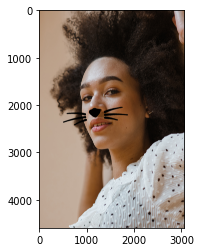

In [29]:
stickerAttacher = StickerAttacher(img_path + 'face/11_1.png')
stickerAttacher.face_detect(True)
stickerAttacher.landmark(True)
stickerAttacher.add_sticker(sticker_path, rotate_sticker=True)

사진을 돌려서 사용해보니 제대로 인식하는 것 같다.  
그렇다면 얼굴 탐색을 회전해서 한 후에 원래대로 돌리면 되지 않을까 해서 detect 함수에 rotate_detect옵션을 추가해 보았다.

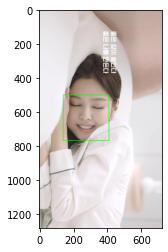

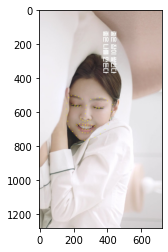

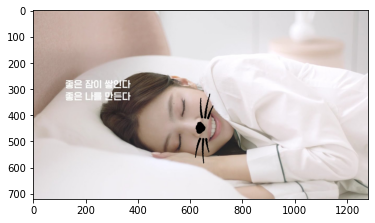

In [30]:
stickerAttacher = StickerAttacher(img_path + 'face/10.png')
stickerAttacher.face_detect(True, rotate_detect=True)
stickerAttacher.landmark(True)
stickerAttacher.add_sticker(sticker_path, rotate_sticker=True)

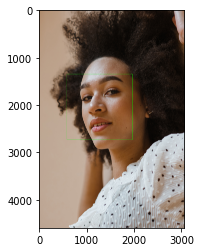

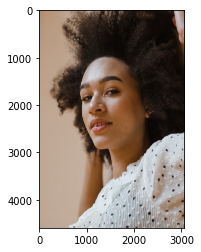

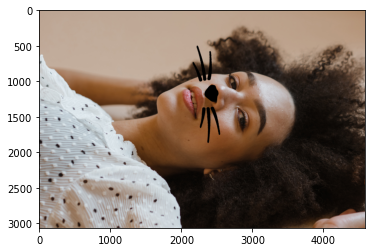

In [31]:
stickerAttacher = StickerAttacher(img_path + 'face/11.png')
stickerAttacher.face_detect(True, rotate_detect=True)
stickerAttacher.landmark(True)
stickerAttacher.add_sticker(sticker_path, rotate_sticker=True)

회전에서 탐색하니 스티커를 성공적으로 붙일 수 있었다.  
하지만 아래 사진은 매우 고해상도의 사진이다보니 탐색하는데 시간도 오래걸렸고 회전하는 횟수만큼 더 오래걸렸다.  
실시간으로 스티커가 어떻게 나타나는지 보여줘야 하는 사진 어플에 써먹을 수는 없지 않을까?

## 7. 회고
1. 일상해서 접했던 것을 직접 만들어 보니 재미있었다. 
2. 스티커 회전과 그림 회전탐색 부분을 구현하면서 opencv의 rotate 부분은 꽤 익숙해진 것 같다. 
3. 해상도가 높은 사진은 탐색이 아주 느리던데 크기를 줄였다가 다시 원본 해상도로 돌리는 것이 가능하다면 탐색시간을 줄이는데 도움이 될 것 같다. 아니면 해상도를 줄인 상태에서 탐색하고 그 부분을 기억했다가 원래 사진에 적용하는 것도 가능하지 않을까 싶다.
4. 제일 큰 사진을 회전탐색했을때 거의 40초가 걸렸는데 사진 크기가 4592x3064였다. 요즘 휴대폰이면 카메라 성능이 완전 좋으니 실시간으로 스티커가 어디 붙는지 보여주려면 속도의 개선이 필요할 것 같다.